# Bengali Fake News Detection with BiLSTM and DistilBERT (PyTorch)
Our project demonstrates fake news detection using BiLSTM and DistilBERT for Bengali text. It includes data loading, preprocessing, visualization, feature extraction, model building, training, and evaluation.

**Note:** The BiLSTMClassifier model uses dropout regularization after feature concatenation and before the dense layer to help prevent overfitting.

In [176]:
# 1. Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.utils import shuffle
from imblearn.under_sampling import TomekLinks
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
from bnlp import BengaliCorpus as corpus
import re
from collections import Counter
import string

In [177]:
print(corpus.stopwords)
print(corpus.punctuations)
print(corpus.letters)
print(corpus.vowels)

['অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা', 'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্', 'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন', 'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে', 'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে', 'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন', 'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু', 'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও'

In [178]:
# 2. Load and Concatenate Bengali Datasets (using headline, category, content)
file1 = pd.read_csv('Fake-1K.csv')
file2 = pd.read_csv('LabeledAuthentic-7K.csv')
file3 = pd.read_csv('Authentic-48K.csv')
file4 = pd.read_csv('LabeledFake-1K.csv')
file5 = pd.read_csv('final_bn_data.csv')
# n_samples = 10000
file1['label'] = 1
file4['label'] = 1
file2['label'] = 0
file3['label'] = 0

df = pd.concat([file1, file2, file3, file4,file5], ignore_index=True)
df = shuffle(df, random_state=42).reset_index(drop=True)
# df=df.groupby('label').sample(n=n_samples, random_state=42).reset_index(drop=True)
print(f"Total samples: {len(df)} | Fake: {df['label'].sum()} | Real: {len(df)-df['label'].sum()}")
print("Columns:", df.columns.tolist())
df=df[['headline','category','content','label']]
df.head()

Total samples: 73015 | Fake: 12598.0 | Real: 60417.0
Columns: ['articleID', 'domain', 'date', 'category', 'headline', 'content', 'label', 'source', 'relation', 'F-type']


,headline,category,content,label
0,কুবি সাংবাদিক সমিতির সেরা হলেন যারা ১০ অক্টোবর...,Education,গত তিন মাসের সংবাদের উপর পর্যালোচনা করে সেরা প...,0.0
1,মেয়েরা ঠিক যেখানে টিপ পরে,Miscellaneous,(ভিয়েতনামের পথে: ৪২তম পর্ব) ফেরদৌস জামান: দুই ...,0.0
2,"ছয় বছর পর ধর্ষকের সঙ্গে দেখা, অতঃপর...",International,নিজের জীবনে ঘটে যাওয়া সেই দুঃসহ স্মৃতি এখনও তা...,0.0
3,ইমরানের জন্য খোলা হলো পবিত্র কাবা শরিফের দরজা ...,International,সবার জন্য পবিত্র কাবা শরিফের ভেতরে প্রবেশের অন...,0.0
4,উইকেটে অভিষেক রাঙালেন আবু হায়দার,Sports,অপেক্ষা শেষে ওয়ানডে দলে সুযোগ মিললো আবু হায়দার...,0.0


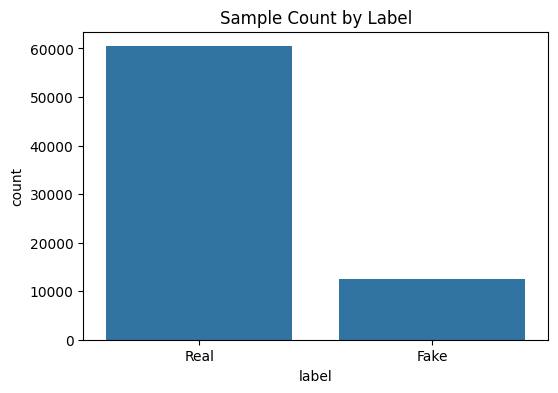

In [179]:
# 3. Data Analysis: Bar Chart for Categories/Labels
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.xticks([0,1], ['Real', 'Fake'])
plt.title('Sample Count by Label')
plt.show()

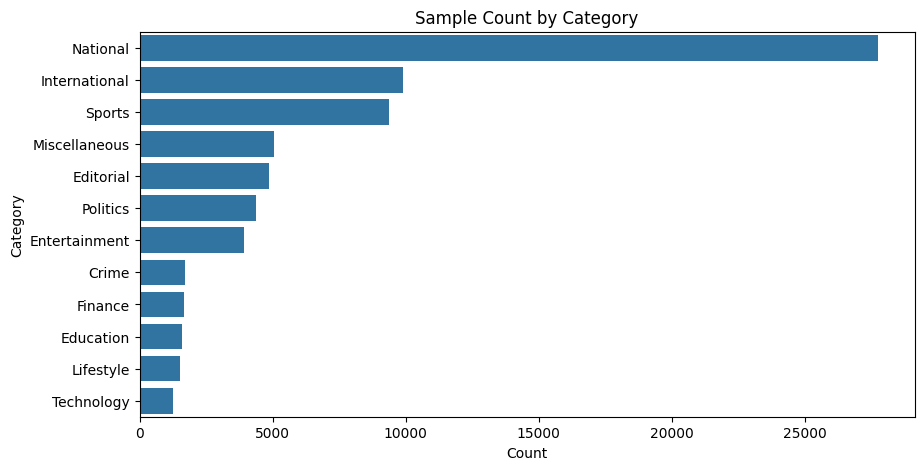

In [180]:
# 3b. Visualization: Bar Chart for Category Distribution
plt.figure(figsize=(10,5))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Sample Count by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

In [181]:
# 4. Preprocessing: Clean Noise, Remove Stopwords, Punctuation, Digits, Letters
bangla_stopwords = set(corpus.stopwords)
def clean_text(text):
    text = str(text)
    text = re.sub(r'[a-zA-Z]', '', text)  # Remove English letters
    text = re.sub(r'\d+', '', text)      # Remove digits
    text = re.sub(rf'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)     # Remove extra spaces
    words = text.split()
    words = [w for w in words if w not in bangla_stopwords]
    return ' '.join(words)

# Combine headline, category, and content for modeling
def combine_text(row):
    return f"{row['headline']} {row['category']} {row['content']}"

df['combined_text'] = df.apply(combine_text, axis=1)
df['clean_text'] = df['combined_text'].apply(clean_text)
df[['headline', 'category', 'content', 'clean_text']].head()

,headline,category,content,clean_text
0,কুবি সাংবাদিক সমিতির সেরা হলেন যারা ১০ অক্টোবর...,Education,গত তিন মাসের সংবাদের উপর পর্যালোচনা করে সেরা প...,কুবি সাংবাদিক সমিতির সেরা হলেন অক্টোবর গত তিন ...
1,মেয়েরা ঠিক যেখানে টিপ পরে,Miscellaneous,(ভিয়েতনামের পথে: ৪২তম পর্ব) ফেরদৌস জামান: দুই ...,মেয়েরা টিপ ভিয়েতনামের পথে তম পর্ব ফেরদৌস জামান...
2,"ছয় বছর পর ধর্ষকের সঙ্গে দেখা, অতঃপর...",International,নিজের জীবনে ঘটে যাওয়া সেই দুঃসহ স্মৃতি এখনও তা...,ছয় বছর ধর্ষকের অতঃপর জীবনে ঘটে দুঃসহ স্মৃতি তা...
3,ইমরানের জন্য খোলা হলো পবিত্র কাবা শরিফের দরজা ...,International,সবার জন্য পবিত্র কাবা শরিফের ভেতরে প্রবেশের অন...,ইমরানের খোলা পবিত্র কাবা শরিফের দরজা ভিডিও পবি...
4,উইকেটে অভিষেক রাঙালেন আবু হায়দার,Sports,অপেক্ষা শেষে ওয়ানডে দলে সুযোগ মিললো আবু হায়দার...,উইকেটে অভিষেক রাঙালেন আবু হায়দার অপেক্ষা শেষে ...


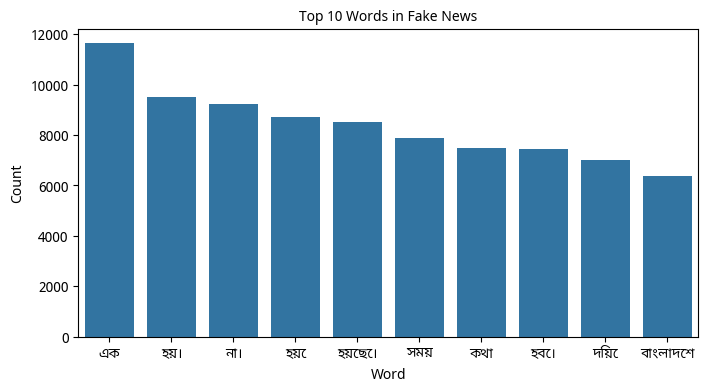

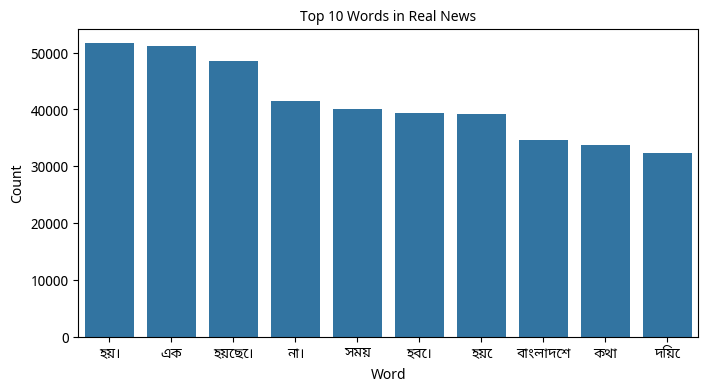

In [182]:
# 5. Top 10 Most Used Words for Fake and Real (Bar Charts)
def plot_top_words(label, title):
    bengali_font_path = "NotoSansBengali-VariableFont_wdth,wght.ttf"
    bengali_font = fm.FontProperties(fname=bengali_font_path)
    
    texts = df[df['label']==label]['clean_text']
    all_words = ' '.join(texts).split()
    common = Counter(all_words).most_common(10)
    words, counts = zip(*common)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(words), y=list(counts))
    plt.title(title, fontproperties=bengali_font)
    plt.ylabel('Count', fontproperties=bengali_font)
    plt.xlabel('Word', fontproperties=bengali_font)
    plt.xticks(fontproperties=bengali_font)
    plt.yticks(fontproperties=bengali_font)
    plt.show()

plot_top_words(1, 'Top 10 Words in Fake News')
plot_top_words(0, 'Top 10 Words in Real News')

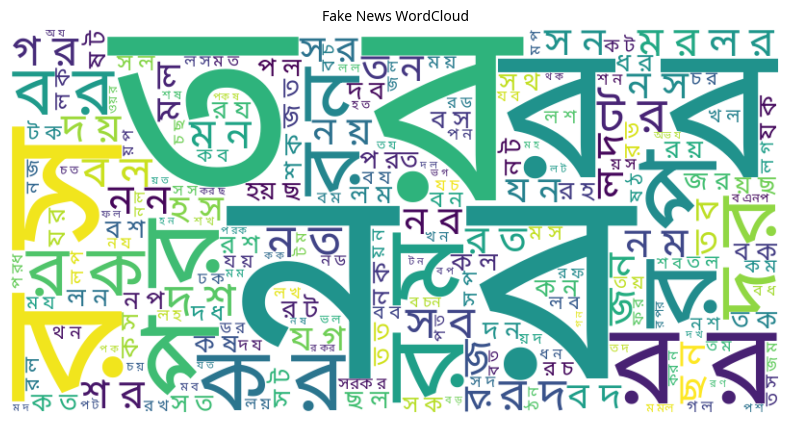

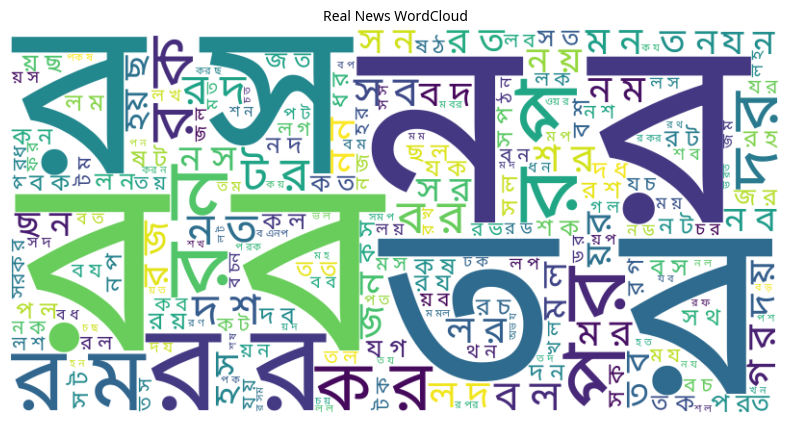

In [183]:
# 6. WordClouds for Fake and Real News
for label, title in zip([1,0], ['Fake News WordCloud', 'Real News WordCloud']):
    bengali_font_path = "NotoSansBengali-VariableFont_wdth,wght.ttf"
    text = ' '.join(df[df['label']==label]['clean_text'])
    wc = WordCloud(font_path=bengali_font_path, width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontproperties=fm.FontProperties(fname=bengali_font_path))
    plt.show()

In [184]:
# 7. Feature Extraction: DistilBERT Tokenization & Embedding
MODEL = 'distilbert-base-multilingual-cased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL)
bert_model = DistilBertModel.from_pretrained(MODEL)

MAX_LEN = 128

class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
    
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

In [185]:
# Example: Get tokenized and embedded output from DistilBERT for a sample text
sample_text = "এটি একটি বাংলা বাক্য।"
encoding = tokenizer(
    sample_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)
print("Tokenized input_ids:", encoding['input_ids'])
print("Attention mask:", encoding['attention_mask'])

with torch.no_grad():
    bert_output = bert_model(
        input_ids=encoding['input_ids'],
        attention_mask=encoding['attention_mask']
    )
print("DistilBERT last_hidden_state shape:", bert_output.last_hidden_state.shape)
print("DistilBERT last_hidden_state:", bert_output.last_hidden_state)

Tokenized input_ids: tensor([[  101, 25757, 14374, 49133, 17660, 13104, 15215,   920,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,  

In [186]:

texts = df['clean_text'].iloc[:2].tolist()
encoding = tokenizer(
    texts,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)
print("Tokenized input_ids shape:", encoding['input_ids'].shape)
print("Tokenized input_ids:", encoding['input_ids'])
print("Attention mask:", encoding['attention_mask'])

Tokenized input_ids shape: torch.Size([2, 128])
Tokenized input_ids: tensor([[   101,    948,  16166,  47356,    978,  12079,  22756,  74765,  15691,
            978,  37376,  66565,  95386,  92576,  11737,  41345,    950,  13542,
          98146,  18601,  54253,    978,  22756,  74765,  11421,  29740,  40685,
         105864,  58914,  95386,  71083,  49178,  17511,  13104,    937,  11737,
          29621,  58052,    968,  74364,  67366,  95386,  71083,  49178,  17511,
          11737,  95386,    969,  12235,  85746,  15258,  26145,    948,  40685,
          36715,  54032,  41602,  45863,  76677,    948,  16166,  37376,  13458,
         111240,  29621,  77952,    978,  12079,  22756,  74765,  15691,    978,
          37376,  29904,  13104,  16166,  47356,  60398,  15258,    920,    970,
          16166,  56251,  36213,  41345,    978,  80180,    978,  37376,  66565,
            948,  15010,  40685,  13458,  24758,  45863,    970,  17460,  40652,
          12711,    920,  95386,  71083,

In [187]:
# 9. Train/Validation Split (use clean_text from combined fields)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

train_dataset = NewsDataset(train_texts.tolist(), train_labels.tolist())
val_dataset = NewsDataset(val_texts.tolist(), val_labels.tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [188]:
# Set device for model and tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [189]:
# 10. Enhanced BiLSTM Model with LayerNorm, Attention, Residual, and Pooling
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_out, mask=None):
        # lstm_out: (batch, seq_len, hidden_dim)
        attn_weights = self.attn(lstm_out).squeeze(-1)  # (batch, seq_len)
        if mask is not None:
            attn_weights = attn_weights.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)
        return attended

class BiLSTMClassifier(nn.Module):
    def __init__(self, bert_model, lstm_units=128, num_layers=2, dense_units=256, dropout_rate=0.5):
        super().__init__()
        self.bert = bert_model
        self.layernorm_in = nn.LayerNorm(768)
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=lstm_units,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.layernorm_out = nn.LayerNorm(lstm_units*2)
        self.attention = Attention(lstm_units*2)
        self.dropout = nn.Dropout(dropout_rate)
        # Pooling output is lstm_units*2 (attn) + lstm_units*2 (avg) + lstm_units*2 (max) + 768 (residual)
        self.fc1 = nn.Linear(lstm_units*2*3 + 768, dense_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dense_units, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # (batch, seq_len, 768)
        x = self.layernorm_in(bert_out)
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, lstm_units*2)
        lstm_out = self.layernorm_out(lstm_out)
        # Attention
        attn_feat = self.attention(lstm_out, mask=attention_mask)
        # Pooling
        avg_pool = torch.mean(lstm_out, dim=1)
        max_pool, _ = torch.max(lstm_out, dim=1)
        # Residual connection: use [CLS] token from BERT (first token)
        residual = bert_out[:, 0, :]  # (batch, 768)
        # Concatenate all features
        final_feat = torch.cat([attn_feat, avg_pool, max_pool, residual], dim=1)
        out = self.dropout(final_feat)  # Dropout applied here
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)

In [190]:
# class BiLSTMClassifier(nn.Module):
#     def __init__(self, bert_model, lstm_units=128, dense_units=256, dropout_rate=0.5):
#         super().__init__()
#         self.bert = bert_model
#         self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_units, num_layers=1, batch_first=True, bidirectional=True)
#                 self.dropout = nn.Dropout(dropout_rate)
#         self.fc1 = nn.Linear(lstm_units*2, dense_units)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(dense_units, 1)
#         self.sigmoid = nn.Sigmoid()
#     def forward(self, input_ids, attention_mask):
#         with torch.no_grad():
#             bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
#         lstm_out, _ = self.lstm(bert_out)
#         out = lstm_out[:,0,:]
#                 out = self.dropout(out)
#         out = self.fc1(out)
#         out = self.relu(out)
#         out = self.fc2(out)
#         return self.sigmoid(out)

In [191]:
from itertools import product

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * input_ids.size(0)
        preds = (outputs > 0.5).float()
        total_correct += (preds == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * input_ids.size(0)
            preds = (outputs > 0.5).float()
            total_correct += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset), np.array(all_labels), np.array(all_preds)

# param_grid = {
#     'optimizer': ['adam', 'rmsprop'],
#     'lstm_units': [64, 128],
#     'dense_units': [32, 256],
#     'dropout_rate': [0.3, 0.5],
#     'batch_size': [16, 32]
# }

def get_optimizer(opt_name, params, lr=2e-5):
    if opt_name == 'adam':
        return optim.Adam(params, lr=lr)
    elif opt_name == 'rmsprop':
        return optim.RMSprop(params, lr=lr)
    else:
        raise ValueError('Unknown optimizer')

# # Generate all combinations
# keys, values = zip(*param_grid.items())
# best_acc = 0
# best_params = None

# for combo in product(*values):
#     params = dict(zip(keys, combo))
#     print(f"Testing params: {params}")

#     # Create new model and optimizer for each run
#     model = BiLSTMClassifier(
#         bert_model,
#         lstm_units=params['lstm_units'],
#         dense_units=params['dense_units'],
#         dropout_rate=params['dropout_rate']
#     ).to(device)
#     optimizer = get_optimizer(params['optimizer'], model.parameters())
#     criterion = nn.BCELoss()

#     # Use batch_size from params
#     train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=params['batch_size'])

#     # Train for 1 epoch (or more for better results)
#     train_epoch(model, train_loader, optimizer, criterion)
#     val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion)
#     print(f"Val Acc: {val_acc:.4f}")

#     if val_acc > best_acc:
#         best_acc = val_acc
#         best_params = params

# print(f"Best Params: {best_params} | Best Val Acc: {best_acc:.4f}")

In [192]:
# Set hyperparameters directly (no grid search)
optimizer_name = 'adam'
lstm_units = 64
dense_units = 256
dropout_rate = 0.3
batch_size = 16

model = BiLSTMClassifier(bert_model, lstm_units=lstm_units, dense_units=dense_units, dropout_rate=dropout_rate).to(device)
optimizer = get_optimizer(optimizer_name, model.parameters())
criterion = nn.BCELoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [193]:
# 12. Training Loop (5 epochs, show val accuracy/loss)
# Use the hyperparameters set above
train_losses, val_losses, val_accuracies = [], [], []
for epoch in range(5):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/5 | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/5 | Train Loss: 0.4610 | Val Loss: 0.4590 | Val Acc: 0.8274
Epoch 2/5 | Train Loss: 0.4584 | Val Loss: 0.4580 | Val Acc: 0.8274
Epoch 3/5 | Train Loss: 0.4569 | Val Loss: 0.4539 | Val Acc: 0.8274
Epoch 4/5 | Train Loss: 0.4547 | Val Loss: 0.4529 | Val Acc: 0.8274
Epoch 5/5 | Train Loss: 0.4531 | Val Loss: 0.4520 | Val Acc: 0.8274


Validation Accuracy: 0.8274
F1 Score: 0.0008
Precision: 0.3333
Recall: 0.0004


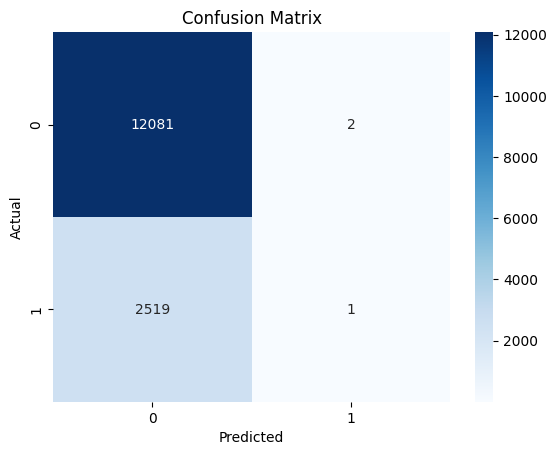

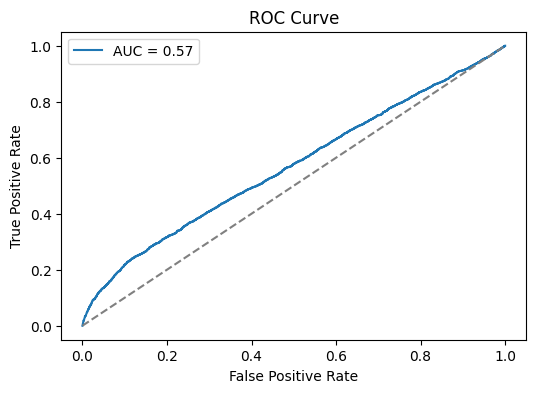

In [194]:
# 13. Evaluation: Accuracy, F1, Precision, Recall, Confusion Matrix, ROC Curve
val_loss, val_acc, y_true, y_pred = eval_epoch(model, val_loader, criterion)
y_pred_label = (y_pred > 0.5).astype(int)

print(f"Validation Accuracy: {accuracy_score(y_true, y_pred_label):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_label):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_label):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_label):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [195]:
torch.save(model.state_dict(), 'bilstm_distilbert_bn.pth')

In [196]:
custom_headline = "আপনার খবরের শিরোনাম এখানে লিখুন"
custom_category = "রাজনীতি"
custom_content = "এখানে খবরের বিস্তারিত লিখুন"

In [197]:
custom_text = f"{custom_headline} {custom_category} {custom_content}"
custom_clean = clean_text(custom_text)
encoding = tokenizer(
    custom_clean,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

In [198]:
model.eval()
with torch.no_grad():
    output = model(input_ids, attention_mask)
    pred = (output.item() > 0.5)
    label = "Fake" if pred else "Real"
    print(f"Prediction: {label}")

Prediction: Real
